## Human Activity Recognition Using Smartphones Data 


## Multilayer Perceptron (MLP)


In [ ]:
# Importing required libraries

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# Using GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Loading the data

from google.colab import drive
drive.mount('/content/drive')

data=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Smartphone/Human_Activity_Recognition_Using_Smartphones_Data.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("Data size: ",data.shape)

Data size:  (10299, 562)


In [ ]:
# Splitting data into input and output

x=data.iloc[:,0:-1]
y=data.iloc[:,-1]

print("Input size: ",x.shape)
print("Output size: ",y.shape)

Input size:  (10299, 561)
Output size:  (10299,)


In [ ]:
# Getting features used for classification

data_header=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Smartphone/Human_Activity_Recognition_Using_Smartphones_Data.csv",header=None)
features=data_header.iloc[0,0:561]

# Arranging feature names for clarity
features = features.str.replace('[()]','')
features = features.str.replace('[-]', '')
features = features.str.replace('[,]','')

# Printing randomly choosen feature samples
import random
print("Some features:\n\n",random.sample(features.values.tolist(), 8),"\n\n\n")


Some features:

 ['tBodyAcccorrelationYZ', 'fBodyAccbandsEnergy4964', 'fBodyAccmaxIndsZ', 'angleZgravityMean', 'tBodyGyroarCoeffY1', 'tBodyGyroMagmean', 'fBodyAccJerkbandsEnergy1724', 'fBodyAccJerkmeanZ'] 





In [ ]:
# Encoding labels with digits

original_label=y

print("\n\n Original label samples:\n\n",y[24:30],"\n\n")

y = y.map({'WALKING':1, 'WALKING_UPSTAIRS':2,'WALKING_DOWNSTAIRS':3,\
                       'SITTING':4, 'STANDING':5,'LAYING':6})

print("\n\n Encoded label samples:\n\n",y[24:30])



 Original label samples:

 24    STANDING
25    STANDING
26    STANDING
27     SITTING
28     SITTING
29     SITTING
Name: Activity, dtype: object 




 Encoded label samples:

 24    5
25    5
26    5
27    4
28    4
29    4
Name: Activity, dtype: int64


Activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
dtype: int64 





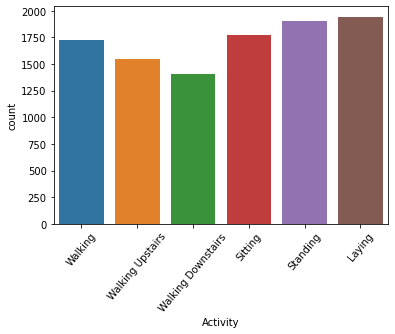

In [ ]:
# Visualizing the count of the activities

print(data_header.value_counts(original_label),"\n\n\n")

g=sns.countplot(y)
g.set_xticklabels(labels=["Walking","Walking Upstairs","Walking Downstairs","Sitting","Standing","Laying"],rotation=50)
plt.show()

In [ ]:
# Splitting data into train and test sets

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
print("Train set length:",x_train.shape[0])
print("Test set length:",x_test.shape[0])

Train set length: 8239
Test set length: 2060


In [ ]:
# Dataframe to tensor 

x_train=torch.tensor(x_train.values)
y_train=torch.tensor(y_train.values)
x_test=torch.tensor(x_test.values)
y_test=torch.tensor(y_test.values)

In [ ]:
# Creating train and test tensors

train=TensorDataset(x_train, y_train)
test=TensorDataset(x_test, y_test)

## Neural Network

In [ ]:
class MLP(nn.Module):
    # Initializing layers which will be used in forward propogation
    def __init__(self):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, num_classes)
    
    # Implementing forward propogation
    def forward(self, x):
        x = x.view(-1, input_size)

        out1=self.fc1(x)
        act1=torch.relu(out1)

        out2=self.fc2(act1)
        act2=torch.relu(out2)

        out3=self.fc3(act2)
        act3=torch.log_softmax(out3, dim=1)

        return act3

In [ ]:
# Defining parameters

num_epochs =30
input_size = 561
hidden1_size=128
hidden2_size=64
num_classes = 7
num_layers=2

In [ ]:
# Determining loss function

criterion = nn.CrossEntropyLoss()

### Tuning batch size, learning rate and epoch number

In [ ]:
for batch_size in [1,10,100]:
    print(f"\n   Batch size: {batch_size}")

    # Defining train and test dataloaders for different batch sizes

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(train, batch_size=batch_size, shuffle=False)


    for learning_rate in [0.01,0.005,0.001]:
      print(f"\n>>Learning rate: {learning_rate}")
      

      # Defining model and optimizer for different batch sizes and learning rates
      model=MLP().to(device) 
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  


      # Training 
      for epoch in range(num_epochs):
        for i,(images,labels) in enumerate(train_loader):
          images = images.to(device) 
          labels=labels.to(device) 

          #forward pass
          train_output=model(images.type(torch.float32))
          optimizer.zero_grad()

          #loss
          train_loss=criterion(train_output,labels)

          #backward pass
          train_loss.backward()

          #update
          optimizer.step()


        
        # Prediction and evaluation
        with torch.no_grad(): 
          score=0
          n_samples=0
          for images,labels in test_loader:
            images =images.to(device) 
            labels=labels.to(device) 

            test_output=model(images.type(torch.float32))
            value, index = torch.max(test_output.data, 1)
            predicted_labels=index

            n_samples+=labels.size(0)
            correct_pred=(predicted_labels == labels)
            score+=correct_pred.sum()

          accuracy= score/n_samples*100
          print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: % {accuracy:.2f}")


   Batch size: 1

>>Learning rate: 0.01
Epoch [1/30], Accuracy: % 45.49
Epoch [2/30], Accuracy: % 51.67
Epoch [3/30], Accuracy: % 49.76
Epoch [4/30], Accuracy: % 56.74
Epoch [5/30], Accuracy: % 47.75
Epoch [6/30], Accuracy: % 55.95
Epoch [7/30], Accuracy: % 54.56
Epoch [8/30], Accuracy: % 56.44
Epoch [9/30], Accuracy: % 58.66
Epoch [10/30], Accuracy: % 57.82
Epoch [11/30], Accuracy: % 60.88
Epoch [12/30], Accuracy: % 60.23
Epoch [13/30], Accuracy: % 61.20
Epoch [14/30], Accuracy: % 60.69
Epoch [15/30], Accuracy: % 61.32
Epoch [16/30], Accuracy: % 62.60
Epoch [17/30], Accuracy: % 62.31
Epoch [18/30], Accuracy: % 61.62
Epoch [19/30], Accuracy: % 62.14
Epoch [20/30], Accuracy: % 62.64
Epoch [21/30], Accuracy: % 59.23
Epoch [22/30], Accuracy: % 62.79
Epoch [23/30], Accuracy: % 63.31
Epoch [24/30], Accuracy: % 61.20
Epoch [25/30], Accuracy: % 62.03
Epoch [26/30], Accuracy: % 32.19
Epoch [27/30], Accuracy: % 60.92
Epoch [28/30], Accuracy: % 62.00
Epoch [29/30], Accuracy: % 58.13
Epoch [30/3

### Implementing model with chosen parameters

In [ ]:
# Defining optimized parameters

batch_size=10
learning_rate=0.001
num_epochs=30

# Defining dataloaders, model and optimizer for chosen batch size, learning rate, and epoch number

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(train, batch_size=batch_size, shuffle=False)

model=MLP().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  



n_iterations=len(train_loader)

# TRAINING

train_loss_list=[]
test_loss_list=[]
accuracy_list=[]
for epoch in range(num_epochs):
  loss_total_train=0
  label_list=[]
  for i,(images,labels) in enumerate(train_loader):
     images = images.to(device) 
     labels=labels.to(device) 

     #forward pass
     train_output=model(images.type(torch.float32))
     optimizer.zero_grad()

     #loss
     train_loss=criterion(train_output,labels)
     loss_total_train+=train_loss

     #backward pass
     train_loss.backward()

     #update
     optimizer.step()

  avg_train_loss=loss_total_train/n_iterations

  # PREDICTION AND EVALUATION
  with torch.no_grad(): 
        score=0
        n_samples=0
        loss_total_test=0
        output_list=[]
        for images,labels in test_loader:
          images = images.to(device)  
          labels=labels.to(device) 
          label_list.extend(labels.numpy())

          test_output=model(images.type(torch.float32))
          value, index = torch.max(test_output.data, 1)
          predicted_labels=index

          n_samples+=labels.size(0)
          correct_pred=(predicted_labels == labels)
          score+=correct_pred.sum()
          output_list.extend(predicted_labels.numpy())

          #test loss
          test_loss=criterion(test_output,labels)
          loss_total_test+=test_loss
        accuracy= score/n_samples*100

        avg_train_loss=loss_total_train/n_iterations
        avg_test_loss=loss_total_test/n_iterations

        accuracy_list.append(accuracy.numpy())
        train_loss_list.append(avg_train_loss.numpy())
        test_loss_list.append(avg_test_loss.numpy())
       


  print (f"Epoch [{epoch+1}/{num_epochs}]: \n train loss= {avg_train_loss:.5f}\n test loss= {avg_test_loss:.5f}\n\n")
print(f"Accuracy:% {accuracy:.2f}")


Epoch [1/30]: 
 train loss= 0.43539
 test loss= 0.15961


Epoch [2/30]: 
 train loss= 0.14936
 test loss= 0.10173


Epoch [3/30]: 
 train loss= 0.10941
 test loss= 0.09165


Epoch [4/30]: 
 train loss= 0.09025
 test loss= 0.10321


Epoch [5/30]: 
 train loss= 0.08603
 test loss= 0.06355


Epoch [6/30]: 
 train loss= 0.07865
 test loss= 0.13044


Epoch [7/30]: 
 train loss= 0.07549
 test loss= 0.05612


Epoch [8/30]: 
 train loss= 0.07414
 test loss= 0.05875


Epoch [9/30]: 
 train loss= 0.06990
 test loss= 0.10370


Epoch [10/30]: 
 train loss= 0.07469
 test loss= 0.07693


Epoch [11/30]: 
 train loss= 0.06221
 test loss= 0.06732


Epoch [12/30]: 
 train loss= 0.06559
 test loss= 0.04622


Epoch [13/30]: 
 train loss= 0.06319
 test loss= 0.05198


Epoch [14/30]: 
 train loss= 0.06585
 test loss= 0.04770


Epoch [15/30]: 
 train loss= 0.05995
 test loss= 0.04430


Epoch [16/30]: 
 train loss= 0.05637
 test loss= 0.09291


Epoch [17/30]: 
 train loss= 0.05941
 test loss= 0.03747


Epoch 

### Model Evaluation

#### Train loss, test loss, accuracy graphs

Text(0.5, 0, 'Epoch number')

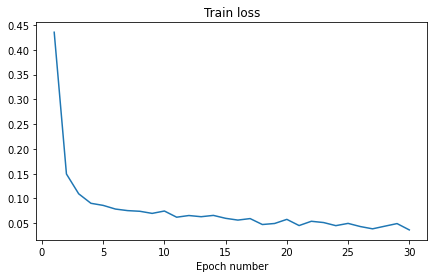

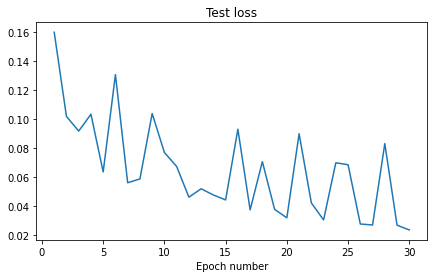

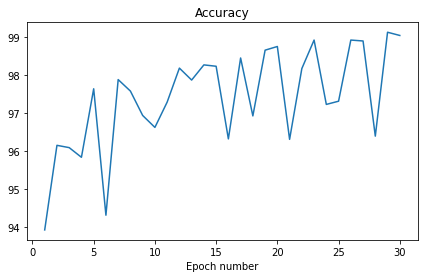

In [ ]:
plt.figure(1, figsize=(7, 4))
plt.plot(np.arange(1,31,1),train_loss_list)
plt.title('Train loss')
plt.xlabel('Epoch number')

plt.figure(2,figsize=(7, 4))
plt.plot(np.arange(1,31,1),test_loss_list)
plt.title('Test loss')
plt.xlabel('Epoch number')

plt.figure(3,figsize=(7, 4))
plt.plot(np.arange(1,31,1),accuracy_list)
plt.title('Accuracy')
plt.xlabel('Epoch number')


#### Confusion Matrix

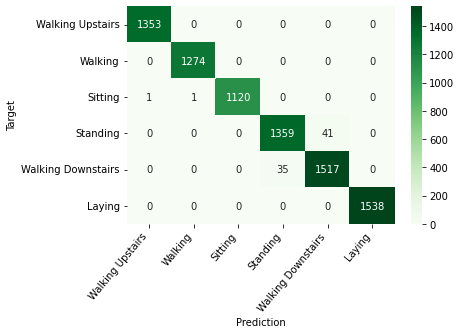

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Greens")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=50, ha='right')
  plt.ylabel('Target')
  plt.xlabel('Prediction');

class_names = ["Walking Upstairs","Walking","Sitting","Standing","Walking Downstairs","Laying"]
cm = confusion_matrix(label_list, output_list)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

#### Precision, recall and f1-score

In [ ]:
print(classification_report(label_list, output_list))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1353
           2       1.00      1.00      1.00      1274
           3       1.00      1.00      1.00      1122
           4       0.97      0.97      0.97      1400
           5       0.97      0.98      0.98      1552
           6       1.00      1.00      1.00      1538

    accuracy                           0.99      8239
   macro avg       0.99      0.99      0.99      8239
weighted avg       0.99      0.99      0.99      8239

